In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import dynamic_range_nms
from utils.set_seed import seed_base

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
seed_base(CFG["env"]["seed"])

2023-11-19 21:08:46.972840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 21:08:47.043802: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-19 21:08:47.529045: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

In [2]:
oof_df = pd.read_parquet(f'/kaggle/output/{CFG["patch_transformer_gru"]["execution"]["exp_id"]}/oof.parquet')
# oof_df = pd.read_csv(f'/kaggle/output/{CFG["xgb_model"]["execution"]["exp_id"]}/oof.csv')
# oof_df = oof_df[oof_df["series_id"].isin(oof_df["series_id"].unique()[:50])]
oof_df.head()

,series_id,step,wakeup_oof,onset_oof
0,05e1944c3818,6,0.471227,0.033161
1,05e1944c3818,18,0.413462,-0.152193
2,05e1944c3818,30,0.376909,-0.293997
3,05e1944c3818,42,0.309498,-0.360509
4,05e1944c3818,54,0.275670,-0.367290


In [3]:
# train = oof_df[oof_df["score"] > 0.01].reset_index(drop=True)
# len(train)

13922239

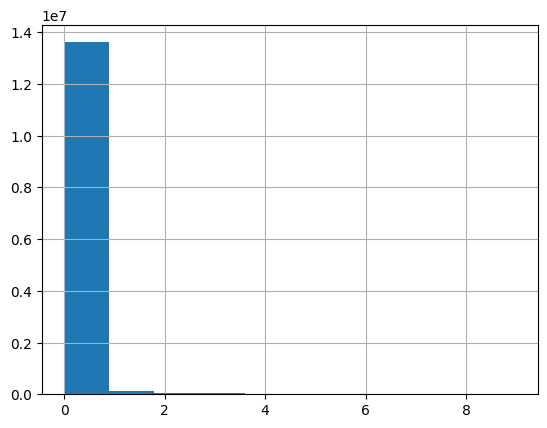

In [4]:
dfs = []
df = oof_df[["series_id", "step", "wakeup_oof"]]
df = df[df["wakeup_oof"] > 0.001]
df["event"] = "wakeup"
df["score"] = df["wakeup_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

df = oof_df[["series_id", "step", "onset_oof"]]
df = df[df["onset_oof"] > 0.001]
df["event"] = "onset"
df["score"] = df["onset_oof"]
dfs.append(df[['series_id', 'step', 'event', 'score']])

train = pd.concat(dfs).reset_index(drop=True)
train["step"] = train["step"].astype(int)
train["score"].hist()
len(train)

In [5]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import sys
import yaml
import matplotlib.pyplot as plt
import gc
from typing import Optional
from scipy.interpolate import interp1d


RANGE = 261
COEFF = 28
EXP = 5

def dynamic_range_nms(df: pd.DataFrame) -> pd.DataFrame:
    """Dynamic-Range NMS

    Parameters
    ----------
    df : pd.DataFrame
        単一のseries_idに対する提出形式
    """
    df = df.sort_values("score", ascending=False).reset_index(drop=True)
    used = []
    used_scores = []
    reduce_rate = np.ones(df["step"].max() + 1000)
    for _ in range(min(len(df), 1000)):
        df["reduced_score"] = df["score"] / reduce_rate[df["step"]]
        best_score = df["reduced_score"].max()
        best_idx = df["reduced_score"].idxmax()
        best_step = df.loc[best_idx, "step"]
        used.append(best_idx)
        used_scores.append(best_score)

        for r in range(1, int(RANGE)):
            reduce = ((RANGE - r) / RANGE) ** EXP * COEFF
            reduce_rate[best_step + r] += reduce
            if best_step - r >= 0:
                reduce_rate[best_step - r] += reduce
        reduce_rate[best_step] = 1e10
    df = df.iloc[used].copy()
    df["reduced_score"] = used_scores
    return df


In [6]:
from multiprocessing import Pool
import optuna

def objective(trial):
    global RANGE, COEFF, EXP
    RANGE = trial.suggest_int("RANGE", 100, 1000)
    COEFF = trial.suggest_int("COEFF", 1, 30)
    EXP = trial.suggest_int("EXP", 1, 10)        

    groups = [group for _, group in train.groupby("series_id")]
    with Pool(30) as p:  
        results = list(p.imap(dynamic_range_nms, groups))
    sub = pd.concat(results)
    sub["score"] = sub["reduced_score"]

    # スコア計算
    labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
    # labels = labels[labels["series_id"].isin(sub["series_id"].unique())].reset_index(drop=True)
    score, ap_table = compute_comptetition_metric(labels, sub)
    return score


study = optuna.create_study(direction="maximize")
study.enqueue_trial({"RANGE": 261, "COEFF": 28, "EXP": 5})
study.enqueue_trial({"RANGE": 917, "COEFF": 11, "EXP": 5})
study.enqueue_trial({"RANGE": 695, "COEFF": 14, "EXP": 3})
study.enqueue_trial({"RANGE": 360, "COEFF": 10, "EXP": 2})
study.enqueue_trial({"RANGE": 638, "COEFF": 17, "EXP": 3})
study.enqueue_trial({"RANGE": 570, "COEFF": 5, "EXP": 3})
study.optimize(objective, n_trials=60)
print(study.best_params)

[I 2023-11-19 21:08:52,093] A new study created in memory with name: no-name-34ab348a-b9a2-436e-9140-def319f2ddfa
[I 2023-11-19 21:09:44,549] Trial 0 finished with value: 0.7997343243224229 and parameters: {'RANGE': 261, 'COEFF': 28, 'EXP': 5}. Best is trial 0 with value: 0.7997343243224229.
[I 2023-11-19 21:10:39,354] Trial 1 finished with value: 0.7902205807710989 and parameters: {'RANGE': 917, 'COEFF': 11, 'EXP': 5}. Best is trial 0 with value: 0.7997343243224229.
[I 2023-11-19 21:11:35,022] Trial 2 finished with value: 0.7849836389604073 and parameters: {'RANGE': 695, 'COEFF': 14, 'EXP': 3}. Best is trial 0 with value: 0.7997343243224229.
[I 2023-11-19 21:12:30,536] Trial 3 finished with value: 0.7941050206792067 and parameters: {'RANGE': 360, 'COEFF': 10, 'EXP': 2}. Best is trial 0 with value: 0.7997343243224229.
[I 2023-11-19 21:13:25,409] Trial 4 finished with value: 0.7844644520019877 and parameters: {'RANGE': 638, 'COEFF': 17, 'EXP': 3}. Best is trial 0 with value: 0.799734324

---